# Tutorial 1: Classify Species with Keras + Tensorflow

In [1]:
import numpy as np

In [2]:
# We don't need all of the data
hg38 = np.load('data/Hsap_Mmus/hg38_1kbp_promoters_100K.npz')['arr_0'][:20000]
mm10 = np.load('data/Hsap_Mmus/mm10_1kbp_promoters_32K.npz')['arr_0'][:20000]

In [3]:
# It's a good practice to look into the data
print('Size of the input tensors: \n \
human: {} \n mouse: {}\n'.format(hg38.shape, mm10.shape))

print('And this is how it looks:')
print(hg38[0,:,150:160])

Size of the input tensors: 
 human: (20000, 4, 1000) 
 mouse: (20000, 4, 1000)

And this is how it looks:
[[ 1.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  1.  1.  0.  0.  0.  1.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]]


In [4]:

# Let's create labels for them: 1 means human, 0 means mouse
# combine the data
labels = np.r_[np.c_[np.ones((hg38.shape[0])),np.zeros((hg38.shape[0]))],
               np.c_[np.zeros((mm10.shape[0])), np.ones((mm10.shape[0]))]]
input_data = np.r_[hg38, mm10]
del hg38, mm10 # we don't need these anymore

# shuffle the data and the labels same way
idx = np.arange(input_data.shape[0])
np.random.shuffle(idx)
input_data = input_data[idx, :, :, None]
labels = labels[idx]


### Split your data into 3: Train, Validation and Test

In [5]:
train_size = int(input_data.shape[0] * 0.9)
valid_size = int(input_data.shape[0] * 0.03)

X_train = input_data[:train_size]
Y_train = labels[:train_size]
X_valid = input_data[train_size:(train_size+valid_size)]
Y_valid = labels[train_size:(train_size+valid_size)]
X_test = input_data[(train_size+valid_size):]
Y_test = labels[(train_size+valid_size):]

print('Train size: {}\nValidation size: {}\nTest size: {}'.format(Y_train.shape[0], Y_valid.shape[0], Y_test.shape[0]))





Train size: 36000
Validation size: 1200
Test size: 2800


## Here's our first model

In [6]:
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.losses import categorical_crossentropy
from keras import backend as K

Using TensorFlow backend.


In [7]:
# Tensorflow creates global variables. Let's clean up before building a new set of variables
tf.reset_default_graph()


In [8]:
# Placeholders
inp = tf.placeholder(tf.float32, [None, 4, 1000, 1], name='dna_input')
target = tf.placeholder(tf.float32, [None, 2], name='label')


net = Conv2D(64, [4, 10],
                activation='relu',
                kernel_regularizer='l2',
                padding='valid',
                name='conv_1')(inp)
net = MaxPooling2D((1, 4), strides=(1, 4))(net)
net = Conv2D(16, [1, 10],
                activation='relu',
                kernel_regularizer='l2',
                padding='valid',
                name='conv_2')(net)
net = MaxPooling2D((1, 4), strides=(1, 4))(net)
net = Flatten()(net)
net = Dropout(0.5)(net)
representation = Dense(50, name='representation')(net)

pred = Dense(2, name='prediction', activation='softmax')(representation)


In [9]:
global_step = tf.Variable(0, name = 'globalStep', trainable = False)

loss = categorical_crossentropy(pred, target)
cost = tf.reduce_mean(loss)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost, global_step=global_step)

In [10]:
# Just to keep track of accuracy:

# For one single out node, sigmoid activation
#accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.greater(pred, 0.5), tf.greater(target, 0.5)), tf.float32))

# For two out node, softmax activation
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred, 1), tf.argmax(target, 1)), tf.float32))


In [12]:
# Now lets look into what variables our tensorflow graph has:
# tf.global_variables()

## Tensorboard and visualizing the model

In [13]:
import sys
sys.path.append('../FIDDLE/fiddle')
from visualization import put_kernels_on_grid

In [14]:
# create and initiate the session
sess = tf.Session()
init = tf.global_variables_initializer() 
sess.run(init)

In [19]:
run_name = 'LR_1e-4_2'
# First convolutional layer weights
weights = [v for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) 
           if 'conv_1/kernel:' in v.name]

grid = put_kernels_on_grid(weights[0])
tf.summary.image('conv1/features', grid)

tf.summary.scalar('Total_cost', cost)
tf.summary.scalar('Accuracy', accuracy)

summary_op = tf.summary.merge_all()
summary_writer_train = tf.summary.FileWriter( run_name+'/train', sess.graph)
summary_writer_valid = tf.summary.FileWriter( run_name+'/validation', sess.graph)



grid: 64 = (8, 8)


In [20]:
# Let's check how it performs with random weights

output, acc = sess.run([pred, accuracy], feed_dict={inp: X_test, target: Y_test, K.learning_phase(): 0})

print('Accuracy prior to training: {}%'.format(100*acc))

Accuracy prior to training: 50.8928596973%


In [21]:
def get_batch(X_train, Y_train, batch_size=50):
    ix = -batch_size
    while True:
        if ix>=(X_train.shape[0]-batch_size):
            ix = -batch_size
        ix+=batch_size
        yield  X_train[ix:(ix+batch_size)],  Y_train[ix:(ix+batch_size)]

In [22]:
batcher = get_batch(X_train, Y_train, 50)
episode = 50
batch_size = 50
step=0
for ix in range(500):
    totloss = 0
    totacc = 0
    for it in range(episode):
        xt, yt = batcher.next()
        _, lss, acc, train_summary = sess.run([optimizer, cost, accuracy, summary_op], 
                                        feed_dict={inp: xt,
                                                   target: yt, K.learning_phase():1})
        totloss+=lss
        totacc+=acc
    lss_test,np_pred, acc_test, validation_summary = sess.run([cost, pred, accuracy, summary_op], feed_dict={inp: X_test,
                                                   target: Y_test, K.learning_phase():0})
    step+=1
    summary_writer_train.add_summary(train_summary, step)
    summary_writer_valid.add_summary(validation_summary, step)
    summary_writer_train.flush()
    summary_writer_valid.flush()
#     print('Train:{}\tAverage loss:{}\tAverage accuracy:%{}'.format(ix, totloss/episode, 100*totacc/episode))
#     print('Validation:{}\tAverage loss:{}\tAverage accuracy:%{}'.format(ix, lss_test, 100*acc_test))

KeyboardInterrupt: 

### Visualize representation

In [23]:
representations = sess.run(representation, feed_dict={inp: X_test, K.learning_phase():0})

In [24]:
representations.shape

(2800, 50)

In [25]:
%matplotlib inline
from matplotlib import pylab as pl

In [26]:
idx = np.argsort(Y_test[:,0])

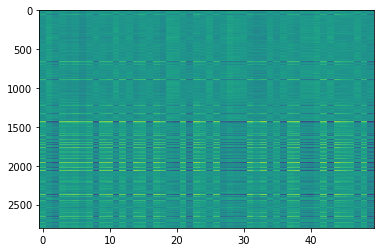

In [27]:
pl.imshow(representations[idx], aspect='auto')

In [28]:
labels = [{1:'human', 0:'mouse'}[ix] for ix in Y_test[:,0]]



In [29]:
import pandas as pd

In [30]:
pd.DataFrame(representations).to_csv('representations_.tsv', sep='\t', header=None, index=None)
pd.DataFrame(labels).to_csv('representations_labels_.tsv', sep='\t', header=None, index=None)

In [ ]:
## Check with projector